# Decadal variablility of GMM in PCA space on reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")

In [2]:
# Load weights
weight_month_mean = xr.open_dataset(
    "../output/pcgmm/pcgmm_1stpaperdraft/pcgmm_weights_month_sst.nc"
)['p_c_given_x']
gmm_order = weight_month_mean.attrs['gmm_sort']

## Decadal variability of Nino3.4

In [3]:
product = 'HadISST' #'COBE2','ErSSTv5','HadISST', 'ORAS5', 'GODAS', 'SODA', 'ERA5', 'CERA-20c' 
dirpath = "../data/reanalysis/monthly/"
datapath = {
    'COBE2':   dirpath+"/COBE/sst_cobe2_month_1850-2019.nc",
    'ErSSTv5': dirpath+"/ERSSTv5/sst_ersstv5_month_1854-present.nc",
    'HadISST': dirpath+"/HadISST/sst_hadisst_month_1870-present.nc",
    'ORAS5':   dirpath+"/ORAS5/sea_surface_temperature_oras5_single_level_1958_2023_1x1.nc",
    'GODAS':   dirpath+"/GODAS/sst_godas_month_1980-present.nc",
    'SODA':    dirpath+"/SODA/sst_SODA_month_1980-2017.nc",
    'ERA5':    dirpath+"/ERA5/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc",
    'CERA-20c':dirpath+"/CERA-20C/sst_cera20c_1901-2009_r1x1.nc",
}

ssta = preproc.process_data(
        datapath[product], vars=['sst'], antimeridian=True,
        climatology='month', normalization=None, detrend_from=1950 
)['ssta']
nino_indices = utenso.get_nino_indices(ssta, antimeridian=True)
nino_indices = nino_indices.sel(time=slice(None, '2021-12-31'))

Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Detrend and compute anomalies:


Monthly weighting of Nino3.4:

In [4]:
weights = weight_month_mean
nino34 = nino_indices['nino34']
# Make sure weights and nino-indices are on the same time points
tmax = nino34['time'].max() if nino34['time'].max() < weights['time'].max() else weights['time'].max()
tmin = nino34['time'].min() if nino34['time'].min() > weights['time'].min() else weights['time'].min()
nino34 = nino34.sel(time=slice(tmin.data, tmax.data)).rolling(time=3, center=True).mean()
weights = weights.sel(time=slice(tmin.data, tmax.data))
weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')
nino34['time'] = np.array(nino34['time'].data, dtype='datetime64[M]')

nino34 = nino34.sel(time=weights['time'])

/tmp/ipykernel_16662/253984587.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')
/tmp/ipykernel_16662/253984587.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by conve

array([<Axes: ylabel='Nino3.4'>, <Axes: xlabel='density'>], dtype=object)

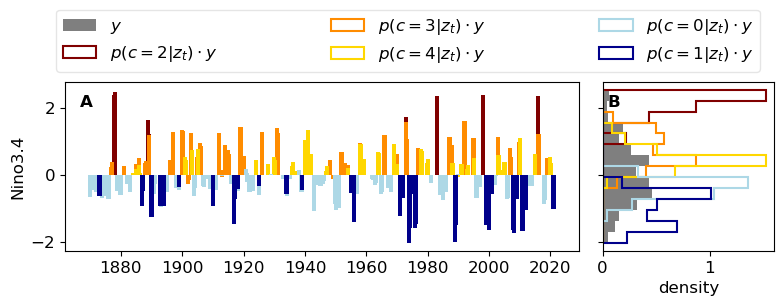

In [6]:
gmclrs = ['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black']
fig, axs = plt.subplots(1, 2, 
                        width_ratios=[3,1],
                        figsize=(8, 2.5),
                        sharey=True)
#axs[0].bar(nino34['time'].data, height=nino34.data, width=4e2, label=rf'y', color='k')
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.5, label=rf'$y$')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.55)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=5e2,
                   color=gmclrs[i])#, label=rf'$p(c={k}|z_t) \cdot y$')
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=rf'$p(c={k}|z_t) \cdot y$')

axs[0].set_ylabel(f'$p_i \cdot y$')
axs[0].set_ylabel("Nino3.4")
axs[1].set_xlabel("density")
#axs[1].legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.07, 1.15, .9, 0.1), mode='expand')
gpl.enumerate_subplots(axs, pos_x=0.03, pos_y=.85, fontsize=12)

### Decadal variability

In [7]:
def rolling_window_covariance(da: xr.DataArray, window_size: int):
    covs = []
    times = []
    for i in range(window_size-1, len(da['time'])):
        # Select window
        chunk = da.isel(time=slice(i-window_size+1, i+1))
        # Compute covariance
        cov = np.cov(chunk.data)
        covs.append(cov)
        times.append(chunk.isel(time=int(window_size/2))['time'].data)
    
    return np.array(covs), np.array(times)


# Weights and Nino3.4 should span same time period
nino34 = nino34.sel(time=slice("1855-12-01", None))
weights = weights.sel(time=slice("1855-12-01", None)) 

# Weighted Nino3.4
nino34_k = []
for k in weights['classes']:
    nino34_k.append(nino34 * weights.sel(classes=k))
nino34_k = xr.concat(nino34_k, dim=pd.Index(weights['classes'].data, name='classes'))

# Rolling mean variance over n_years
n_years = 30
nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))

# Sum of covariances
n_times, n_features, _ = nino34_k_cov.shape
sum_covariances = np.zeros(n_times)
for i in range(n_features):
    for j in range(i+1, n_features):
        sum_covariances += nino34_k_cov.data[:, i, j]
nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))

In [8]:
# Stack plot every 10 years
n_step = 10
# Time points
year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                     np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                     step=n_step, dtype='datetime64[Y]')
time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
# Select time points and stack plots
stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                  ) for k in gmm_order]
stacked_lines.append(
    nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
)

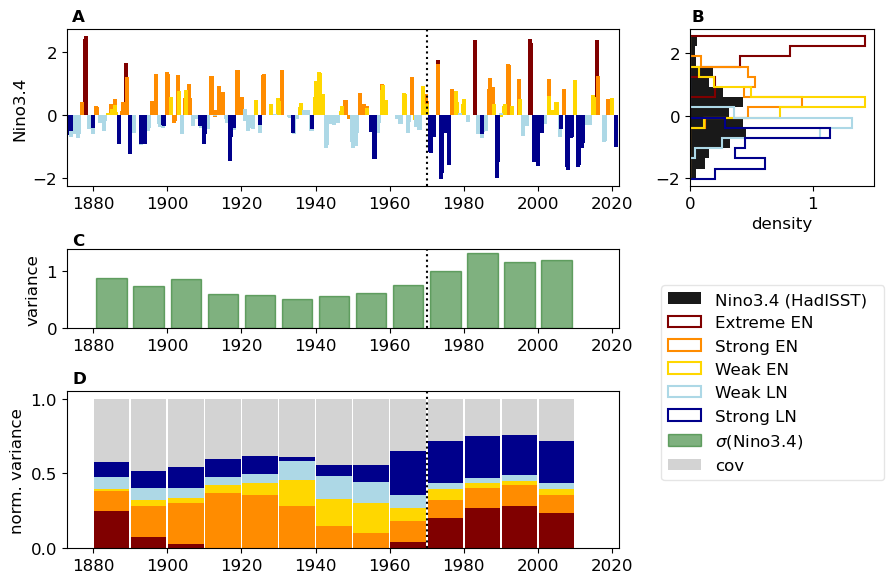

In [11]:
import matplotlib.gridspec as gridspec
class_names = ['Extreme EN', 'Strong EN', 'Weak EN', 'Weak LN', 'Strong LN',]
clrs = gmclrs[:len(gmm_order)]
clrs.append('lightgrey')
labels = [rf"k={k}" for k in gmm_order]
labels.append("cov")
nrows, ncols = (3, 2)
fig = plt.figure(figsize=(9, nrows*2.))
gs = gridspec.GridSpec(nrows, ncols, width_ratios=[3,1], height_ratios=[2,1,2])
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
axs.append(fig.add_subplot(gs[1,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[2,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[1:,1]))

# Nino34 time-series and hisplot
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.9, label=f'Nino3.4 ({product})')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.5)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=4e2,
                   color=gmclrs[i])
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=class_names[i])
#                label=r'$p(c_{k}|z_t) \cdot y$'.replace('k', str(k+1)))
axs[0].set_xlim(np.min(n34_k['time']).data, np.max(n34_k['time']).data)
axs[0].set_ylabel("Nino3.4")
axs[0].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

axs[1].set_xlabel(r"density")

# Variance of Nino34
years = np.arange(np.array(nino34_var['time'].min().data, dtype='datetime64[Y]'),
                  np.array(nino34_var['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                  step=10, dtype='datetime64[Y]')
variance = nino34_var.sel(time=years, method='nearest')
#axs[2].plot(nino34_var['time'], nino34_var, color='darkgreen',
#           label=r'$\sigma_{30y}$ (Nino3.4)')
#axs[2].fill_between(nino34_var['time'], np.zeros(len(nino34_var['time'])), nino34_var, color='darkgreen', alpha=.5)
axs[2].bar(years, height=variance, width=3e3, color='darkgreen', edgecolor='darkgreen', alpha=.5, 
           label=r'$\sigma$(Nino3.4)')
axs[2].set_ylabel(r"variance")
axs[2].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Decadel variability
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    axs[3].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack.data
axs[3].set_ylabel(r"norm. variance")
axs[3].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Legend in seperate subplot
hands, labs = axs[1].get_legend_handles_labels()
hand2, lab2 = axs[2].get_legend_handles_labels()
hand3, lab3 = axs[3].get_legend_handles_labels()
hands.append(hand2[-1])
hands.append(hand3[-1])
labs.append(lab2[-1])
labs.append(lab3[-1])
axs[4].legend(hands, labs, bbox_to_anchor=(-.2, .2, 1.3, 1.), loc="lower left", mode='expand')
axs[4].axis('off')

_ = gpl.enumerate_subplots(axs[:4], pos_x=0.01, pos_y=1.05, fontsize=12)

if True:
    plt.savefig("../output/plots/pcgmm_decadal_variability.png", dpi=300, bbox_inches="tight")

### Check consistency with duration of window

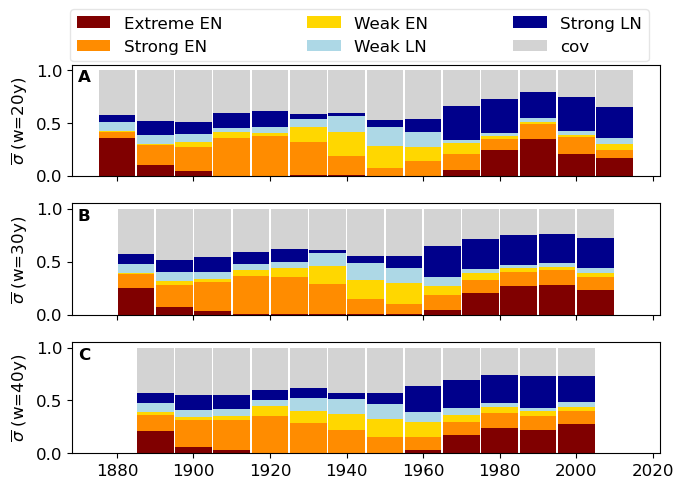

In [13]:
n_step = 10
window_arr = [20, 30, 40]
nrows = len(window_arr) 
class_names = ['Extreme EN', 'Strong EN', 'Weak EN', 'Weak LN', 'Strong LN', 'cov']

fig, axs = plt.subplots(nrows, 1, figsize=(7, nrows*1.5), sharex=True)


for i, n_years in enumerate(window_arr):
    nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
    nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
    nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
    nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))
    
    # Sum of covariances
    n_times, n_features, _ = nino34_k_cov.shape
    sum_covariances = np.zeros(n_times)
    for j in range(n_features):
        for k in range(j+1, n_features):
            sum_covariances += nino34_k_cov.data[:, j, k]
    nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))
    
    year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                         np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                         step=n_step, dtype='datetime64[Y]')
    time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
    # Select time points and stack plots
    stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                      ) for k in gmm_order]
    stacked_lines.append(
        nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
    )

    # Decadel variability
    bottom = np.zeros_like(stacked_lines[0])
    for j, stack in enumerate(stacked_lines):
        if i == 0:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j], label=class_names[j])
        else:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j])
        bottom += stack
    axs[i].set_ylabel(r"$\overline{\sigma}$ " + f"(w={n_years}y)")

fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.1, 1.0, .85, 0.1), mode='expand')
gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.85, fontsize=12)

plt.savefig("../output/plots/pcgmm_decadal_variability_window.png", dpi=300, bbox_inches="tight")
